# Pandas, SQL, and the Grammar of Data

## Table of Contents

* Pandas, SQL, and the Grammar of Data
    * Populating the Database
        * SQLITE
        * Init
            * Populating with Pandas!!
            * Or populate with SQL INSERT
            * Bulk insert
    * Single Table Verbs
        * QUERY
        * SORT
        * SELECT-COLUMNS
        * SELECT-DISTINCT
        * ASSIGN
        * AGGREGATE
        * GROUP-AGG
        * DELETE
        * LIMIT
    * Indexes
    * Relationships: JOINs are Cartesian Products.
        * Simple subselect
        * implicit join
        * Explicit INNER JOIN
        * Outer JOIN
            * left outer (contributors on candidates)
            * right outer (contributors on candidates) = left outer (candidates on contributors)
            * full outer
    * Pandas /SQL
    * Useful Links

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Populating the Database

Lets start with Relational Databases, so called because they contain "relations" (tables), which are SETS of "tuples" (rows) which map "attributes" to atomic values.

The available attributes are constrained by a "header" tuple of attributes which set the type. We do this below here.

In [2]:
ourschema="""
DROP TABLE IF EXISTS "candidates";
DROP TABLE IF EXISTS "contributors";
CREATE TABLE "candidates" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "first_name" VARCHAR,
    "last_name" VARCHAR,
    "middle_name" VARCHAR,
    "party" VARCHAR NOT NULL
);
CREATE TABLE "contributors" (
    "id" INTEGER PRIMARY KEY  AUTOINCREMENT  NOT NULL,
    "last_name" VARCHAR,
    "first_name" VARCHAR,
    "middle_name" VARCHAR,
    "street_1" VARCHAR,
    "street_2" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "zip" VARCHAR,
    "amount" INTEGER,
    "date" DATETIME,
    "candidate_id" INTEGER NOT NULL,
    FOREIGN KEY(candidate_id) REFERENCES candidates(id)
);
"""

## SQLITE

We use sqlite here (and recommend Postgres for production purposes). Still sqlite is great for on-disk large databases which wont fit into memory.

Its also built into Python, but to use the command line tool, I recommend you install it: https://www.sqlite.org/download.html. I also recommend you download and install the sqlite browser: http://sqlitebrowser.org .

Python implements a standard database API over all databases. Its called DBAPI2 http://cewing.github.io/training.codefellows/lectures/day21/intro_to_dbapi2.html. It works across many SQL databases.

There is an even higher level API available, called SQLAlchemy http://www.sqlalchemy.org/. While we wont use it here, I thoroughly recommend it, either in its direct relational form, or ORM form. Many things in Pandas use it to interface with databases. Here we'll get away with things by using SQLITE.

Sqlite is a text or memory based database. Connect and get a DBAPI2 connection.

In [3]:
from sqlite3 import dbapi2 as sq3
import os
PATHSTART="."
def get_db(dbfile):
    sqlite_db = sq3.connect(os.path.join(PATHSTART, dbfile))
    return sqlite_db

Drop tables if they exist and create them.

In [4]:
def init_db(dbfile, schema):
    """Creates the database tables."""
    db = get_db(dbfile)
    db.cursor().executescript(schema)
    db.commit()
    return db

Use Pandas to read in the data

In [5]:
dfcand=pd.read_csv("C:/Users/502689880/candidates.txt", sep='|')
dfcand

,id,first_name,last_name,middle_name,party
0,33,Joseph,Biden,NaN,D
1,36,Samuel,Brownback,NaN,R
2,34,Hillary,Clinton,R.,D
3,39,Christopher,Dodd,J.,D
4,26,John,Edwards,NaN,D
5,22,Rudolph,Giuliani,NaN,R
6,24,Mike,Gravel,NaN,D
7,16,Mike,Huckabee,NaN,R
8,30,Duncan,Hunter,NaN,R
9,31,Dennis,Kucinich,NaN,D


In [6]:
dfcwci=pd.read_csv("C:/Users/502689880/contributors_with_candidate_id.txt", sep="|")
dfcwci.head()

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,NaN,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
1,NaN,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16
2,NaN,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16
3,NaN,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16
4,NaN,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16


In [7]:
del dfcwci['id']
dfcwci.head()

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
1,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16
2,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16
3,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16


### Init

Initializing the database

In [8]:
db=init_db("cancont.db", ourschema)

**Populating with Pandas!!**

In [9]:
dfcand.to_sql("candidates", db, if_exists="append", index=False)

In [10]:
dfcwci.to_sql("contributors", db, if_exists="append", index=False)

In [11]:
dfcwci.shape

(175, 11)

In [12]:
sel="""
SELECT * FROM candidates;
"""
c=db.cursor().execute(sel)

In [13]:
c.fetchall()

[(16, 'Mike', 'Huckabee', None, 'R'),
 (20, 'Barack', 'Obama', None, 'D'),
 (22, 'Rudolph', 'Giuliani', None, 'R'),
 (24, 'Mike', 'Gravel', None, 'D'),
 (26, 'John', 'Edwards', None, 'D'),
 (29, 'Bill', 'Richardson', None, 'D'),
 (30, 'Duncan', 'Hunter', None, 'R'),
 (31, 'Dennis', 'Kucinich', None, 'D'),
 (32, 'Ron', 'Paul', None, 'R'),
 (33, 'Joseph', 'Biden', None, 'D'),
 (34, 'Hillary', 'Clinton', 'R.', 'D'),
 (35, 'Mitt', 'Romney', None, 'R'),
 (36, 'Samuel', 'Brownback', None, 'R'),
 (37, 'John', 'McCain', None, 'R'),
 (38, 'Tom', 'Tancredo', None, 'R'),
 (39, 'Christopher', 'Dodd', 'J.', 'D'),
 (41, 'Fred', 'Thompson', 'D.', 'R')]

In [14]:
rem="""
DELETE FROM candidates;
"""
c=db.cursor().execute(rem)
db.commit()

In [15]:
c.fetchall()

[]

**Or populate with SQL INSERT**

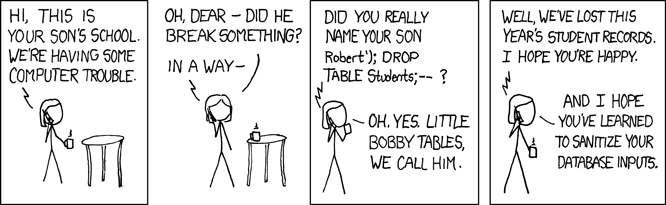

In [16]:
ins="""
INSERT INTO candidates (id, first_name, last_name, middle_name, party) \
    VALUES (?,?,?,?,?);
"""
with open("candidates.txt") as fd:
    slines =[l.strip().split('|') for l in fd.readlines()]
    for line in slines[1:]:
        theid, first_name, last_name, middle_name, party = line
        print (theid, first_name, last_name, middle_name, party)
        valstoinsert = (int(theid), first_name, last_name, middle_name, party)
        print (ins, valstoinsert)
        db.cursor().execute(ins, valstoinsert)

33 Joseph Biden  D

INSERT INTO candidates (id, first_name, last_name, middle_name, party)     VALUES (?,?,?,?,?);
 (33, 'Joseph', 'Biden', '', 'D')
36 Samuel Brownback  R

INSERT INTO candidates (id, first_name, last_name, middle_name, party)     VALUES (?,?,?,?,?);
 (36, 'Samuel', 'Brownback', '', 'R')
34 Hillary Clinton R. D

INSERT INTO candidates (id, first_name, last_name, middle_name, party)     VALUES (?,?,?,?,?);
 (34, 'Hillary', 'Clinton', 'R.', 'D')
39 Christopher Dodd J. D

INSERT INTO candidates (id, first_name, last_name, middle_name, party)     VALUES (?,?,?,?,?);
 (39, 'Christopher', 'Dodd', 'J.', 'D')
26 John Edwards  D

INSERT INTO candidates (id, first_name, last_name, middle_name, party)     VALUES (?,?,?,?,?);
 (26, 'John', 'Edwards', '', 'D')
22 Rudolph Giuliani  R

INSERT INTO candidates (id, first_name, last_name, middle_name, party)     VALUES (?,?,?,?,?);
 (22, 'Rudolph', 'Giuliani', '', 'R')
24 Mike Gravel  D

INSERT INTO candidates (id, first_name, last_name

In [17]:
def make_query(sel):
    c=db.cursor().execute(sel)
    return c.fetchall()

In [18]:
make_query("SELECT * FROM candidates;")

[(16, 'Mike', 'Huckabee', '', 'R'),
 (20, 'Barack', 'Obama', '', 'D'),
 (22, 'Rudolph', 'Giuliani', '', 'R'),
 (24, 'Mike', 'Gravel', '', 'D'),
 (26, 'John', 'Edwards', '', 'D'),
 (29, 'Bill', 'Richardson', '', 'D'),
 (30, 'Duncan', 'Hunter', '', 'R'),
 (31, 'Dennis', 'Kucinich', '', 'D'),
 (32, 'Ron', 'Paul', '', 'R'),
 (33, 'Joseph', 'Biden', '', 'D'),
 (34, 'Hillary', 'Clinton', 'R.', 'D'),
 (35, 'Mitt', 'Romney', '', 'R'),
 (36, 'Samuel', 'Brownback', '', 'R'),
 (37, 'John', 'McCain', '', 'R'),
 (38, 'Tom', 'Tancredo', '', 'R'),
 (39, 'Christopher', 'Dodd', 'J.', 'D'),
 (41, 'Fred', 'Thompson', 'D.', 'R')]

In [19]:
rem="""
DELETE FROM candidates;
"""
c=db.cursor().execute(rem)
db.commit()

**Bulk insert**

You almost always have to do this from the command line. Its typically faster, but also different foe every database

In [20]:
%%bash
tail -n +2 candidates.txt > candidates_nohead.txt
echo ".import candidates_nohead.txt candidates" | sqlite3 cancont.db

In [21]:
make_query("SELECT * FROM candidates;")

[(16, 'Mike', 'Huckabee', '', 'R'),
 (20, 'Barack', 'Obama', '', 'D'),
 (22, 'Rudolph', 'Giuliani', '', 'R'),
 (24, 'Mike', 'Gravel', '', 'D'),
 (26, 'John', 'Edwards', '', 'D'),
 (29, 'Bill', 'Richardson', '', 'D'),
 (30, 'Duncan', 'Hunter', '', 'R'),
 (31, 'Dennis', 'Kucinich', '', 'D'),
 (32, 'Ron', 'Paul', '', 'R'),
 (33, 'Joseph', 'Biden', '', 'D'),
 (34, 'Hillary', 'Clinton', 'R.', 'D'),
 (35, 'Mitt', 'Romney', '', 'R'),
 (36, 'Samuel', 'Brownback', '', 'R'),
 (37, 'John', 'McCain', '', 'R'),
 (38, 'Tom', 'Tancredo', '', 'R'),
 (39, 'Christopher', 'Dodd', 'J.', 'D'),
 (41, 'Fred', 'Thompson', 'D.', 'R')]

### Single Table Verbs

Let us now focus on core data manipulation commands. The reason to do this is that they are *universal across systems, and by identifying them, we can quickly ask how to do these* when we encounter a new system.

See https://gist.github.com/TomAugspurger/6e052140eaa5fdb6e8c0/ which has a comparison of r/dplyr and pandas. I stole and modified this table from there:

`dplyr` has a small set of nicely defined verbs. I've listed their closest pandas verbs.

|VERB | dplyr | pandas | SQL|
|---------------------------|
|QUERY/SELECTION | filter() (and slice()) | query() (and loc[], iloc[]) | SELECT WHERE|
|SORT | arrange() | sort() | ORDER BY|
|SELECT-COLUMNS/PROJECTION | select() (and rename()) | [](__getitem__) (and rename()) | SELECT COLUMN|
|SELECT-DISTINCT | distinct() | unique(),drop_duplicates() | SELECT DISTINCT COLUMN|
|ASSIGN | mutate() (and transmute()) | assign | ALTER/UPDATE|
|AGGREGATE | summarise() | describe(), mean(), max() | None, AVG(),MAX()|
|SAMPLE | sample_n() and sample_frac() | sample() | implementation dep, use RAND()|
|GROUP-AGG | group_by/summarize | groupby/agg, count, mean | GROUP BY|
|DELETE | ? | drop/masking | DELETE/WHERE|

In [22]:
dfcwci.head()

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
1,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16
2,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16
3,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16


### QUERY

In [23]:
dfcwci.query("state=='VA' & amount < 400")

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
27,Buckheit,Bruce,NaN,8904 KAREN DR,NaN,FAIRFAX,VA,220312731,100.00,2007-09-19,20
77,Ranganath,Anoop,NaN,2507 Willard Drive,NaN,Charlottesville,VA,22903,-100.00,2008-04-21,32
88,Perreault,Louise,NaN,503 Brockridge Hunt Drive,NaN,Hampton,VA,23666,-34.08,2008-04-21,32
145,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,NaN,FAIRFAX,VA,220308440,50.00,2007-09-30,35


In [24]:
dfcwci[(dfcwci.state=='VA') & (dfcwci.amount < 400)]

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
27,Buckheit,Bruce,NaN,8904 KAREN DR,NaN,FAIRFAX,VA,220312731,100.00,2007-09-19,20
77,Ranganath,Anoop,NaN,2507 Willard Drive,NaN,Charlottesville,VA,22903,-100.00,2008-04-21,32
88,Perreault,Louise,NaN,503 Brockridge Hunt Drive,NaN,Hampton,VA,23666,-34.08,2008-04-21,32
145,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,NaN,FAIRFAX,VA,220308440,50.00,2007-09-30,35


In [25]:
cont_cols = [e[1] for e in make_query("PRAGMA table_info(contributors);")]
cont_cols

['id',
 'last_name',
 'first_name',
 'middle_name',
 'street_1',
 'street_2',
 'city',
 'state',
 'zip',
 'amount',
 'date',
 'candidate_id']

In [26]:
def make_frame(list_of_tuples, legend=cont_cols):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_items(framelist)

In [27]:
out=make_query("SELECT * FROM contributors WHERE state='VA' AND amount < 400;")
print (out)
make_frame(out)

[(28, 'Buckheit', 'Bruce', None, '8904 KAREN DR', None, 'FAIRFAX', 'VA', '220312731', 100, '2007-09-19', 20), (78, 'Ranganath', 'Anoop', None, '2507 Willard Drive', None, 'Charlottesville', 'VA', '22903', -100, '2008-04-21', 32), (89, 'Perreault', 'Louise', None, '503 Brockridge Hunt Drive', None, 'Hampton', 'VA', '23666', -34.08, '2008-04-21', 32), (146, 'ABDELLA', 'THOMAS', 'M.', '4231 MONUMENT WALL WAY #340', None, 'FAIRFAX', 'VA', '220308440', 50, '2007-09-30', 35)]


,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,28,Buckheit,Bruce,None,8904 KAREN DR,None,FAIRFAX,VA,220312731,100.00,2007-09-19,20
1,78,Ranganath,Anoop,None,2507 Willard Drive,None,Charlottesville,VA,22903,-100.00,2008-04-21,32
2,89,Perreault,Louise,None,503 Brockridge Hunt Drive,None,Hampton,VA,23666,-34.08,2008-04-21,32
3,146,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,None,FAIRFAX,VA,220308440,50.00,2007-09-30,35


In [28]:
out=make_query("SELECT * FROM contributors WHERE state IS NULL;")
make_frame(out)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,126,BOURNE,TRAVIS,None,LAGE KAART 77,None,BRASSCHATT,None,2930,-500,2008-11-20,35


In [29]:
dfcwci[dfcwci.state.isnull()]

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
125,BOURNE,TRAVIS,NaN,LAGE KAART 77,NaN,BRASSCHATT,NaN,2930,-500.0,2008-11-20,35


In [30]:
out=make_query("SELECT * FROM contributors WHERE state IS NOT NULL;")
make_frame(out).shape

(174, 12)

In [31]:
dfcwci[dfcwci.state.notnull()].shape

(174, 11)

In [32]:
out=make_query("SELECT * FROM contributors WHERE state IN ('VA','WA');")
make_frame(out).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,1,Agee,Steven,None,549 Laurel Branch Road,None,Floyd,VA,24091,500.00,2007-06-30,16
1,28,Buckheit,Bruce,None,8904 KAREN DR,None,FAIRFAX,VA,220312731,100.00,2007-09-19,20
2,63,BURKE,SUZANNE,M.,3401 EVANSTON,None,SEATTLE,WA,981038677,-700.00,2008-03-05,22
3,78,Ranganath,Anoop,None,2507 Willard Drive,None,Charlottesville,VA,22903,-100.00,2008-04-21,32
4,89,Perreault,Louise,None,503 Brockridge Hunt Drive,None,Hampton,VA,23666,-34.08,2008-04-21,32
5,101,Aaronson,Rebecca,None,2000 Village Green Dr Apt 12,None,Mill Creek,WA,980125787,100.00,2008-02-08,34
6,107,Aaronson,Rebecca,None,2000 Village Green Dr Apt 12,None,Mill Creek,WA,980125787,100.00,2008-02-14,34
7,146,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,None,FAIRFAX,VA,220308440,50.00,2007-09-30,35


In [33]:
dfcwci[dfcwci.state.isin(['VA','WA'])].head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.00,2007-06-30,16
27,Buckheit,Bruce,NaN,8904 KAREN DR,NaN,FAIRFAX,VA,220312731,100.00,2007-09-19,20
62,BURKE,SUZANNE,M.,3401 EVANSTON,NaN,SEATTLE,WA,981038677,-700.00,2008-03-05,22
77,Ranganath,Anoop,NaN,2507 Willard Drive,NaN,Charlottesville,VA,22903,-100.00,2008-04-21,32
88,Perreault,Louise,NaN,503 Brockridge Hunt Drive,NaN,Hampton,VA,23666,-34.08,2008-04-21,32
100,Aaronson,Rebecca,NaN,2000 Village Green Dr Apt 12,NaN,Mill Creek,WA,980125787,100.00,2008-02-08,34
106,Aaronson,Rebecca,NaN,2000 Village Green Dr Apt 12,NaN,Mill Creek,WA,980125787,100.00,2008-02-14,34
145,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,NaN,FAIRFAX,VA,220308440,50.00,2007-09-30,35


In [34]:
out=make_query("SELECT * FROM contributors WHERE amount BETWEEN 10 AND 50;")
make_frame(out).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,3,Ahrens,Don,None,4034 Rennellwood Way,None,Pleasanton,CA,94566,50,2007-06-18,16
1,19,Ardle,William,None,412 Dakota Avenue,None,Springfield,OH,45504,50,2007-06-28,16
2,26,Buckler,Steve,None,24351 Armada Dr,None,Dana Point,CA,926291306,50,2007-07-30,20
3,27,Buckler,Steve,None,24351 Armada Dr,None,Dana Point,CA,926291306,25,2007-08-16,20
4,35,Buck,Barbara,None,1780 NE 138th St,None,North Miami,FL,331811316,50,2007-09-13,20
5,36,Buck,Barbara,None,1780 NE 138th St,None,North Miami,FL,331811316,50,2007-07-19,20
6,39,Buchanek,Elizabeth,None,7917 Kentbury Dr,None,Bethesda,MD,208144615,50,2007-09-30,20
7,50,Harrison,Ryan,None,2247 3rd St,None,La Verne,CA,917504918,25,2007-07-26,20
8,102,Aarons,Elaine,None,481 Buck Island Rd Apt 17A,APT 17A,West Yarmouth,MA,26733300,25,2008-02-26,34
9,105,Aaron,Shirley,None,101 Cherry Ave,None,Havana,FL,323331311,50,2008-02-29,34


In [35]:
dfcwci.query("10 <= amount <= 50").head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
2,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16
18,Ardle,William,NaN,412 Dakota Avenue,NaN,Springfield,OH,45504,50.0,2007-06-28,16
25,Buckler,Steve,NaN,24351 Armada Dr,NaN,Dana Point,CA,926291306,50.0,2007-07-30,20
26,Buckler,Steve,NaN,24351 Armada Dr,NaN,Dana Point,CA,926291306,25.0,2007-08-16,20
34,Buck,Barbara,NaN,1780 NE 138th St,NaN,North Miami,FL,331811316,50.0,2007-09-13,20
35,Buck,Barbara,NaN,1780 NE 138th St,NaN,North Miami,FL,331811316,50.0,2007-07-19,20
38,Buchanek,Elizabeth,NaN,7917 Kentbury Dr,NaN,Bethesda,MD,208144615,50.0,2007-09-30,20
49,Harrison,Ryan,NaN,2247 3rd St,NaN,La Verne,CA,917504918,25.0,2007-07-26,20
101,Aarons,Elaine,NaN,481 Buck Island Rd Apt 17A,APT 17A,West Yarmouth,MA,26733300,25.0,2008-02-26,34
104,Aaron,Shirley,NaN,101 Cherry Ave,NaN,Havana,FL,323331311,50.0,2008-02-29,34


### SORT

sort_values http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html

sort_index http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_index.html

In [36]:
dfcwci.sort_values("amount").head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
90,Kazor,Christopher,M,707 Spindletree ave,NaN,Naperville,IL,60565,-2592.0,2008-04-21,32
72,BRUNO,JOHN,NaN,10136 WINDERMERE CHASE BLVD.,NaN,GOTHA,FL,347344707,-2300.0,2008-03-06,22
64,BURKE,DONALD,J.,12 LOMPOC,NaN,RANCHO SANTA MARGA,CA,926881817,-2300.0,2008-03-11,22
73,BRUNO,IRENE,NaN,10136 WINDERMERE CHASE BLVD.,NaN,GOTHA,FL,347344707,-2300.0,2008-03-06,22
74,BROWN,TIMOTHY,J.,26826 MARLOWE COURT,NaN,STEVENSON RANCH,CA,913811020,-2300.0,2008-03-06,22
58,BURTON,GLENN,M.,4404 CHARLESTON COURT,NaN,TAMPA,FL,336092620,-2300.0,2008-03-05,22
57,BURTON,STEVEN,G.,9938 DEER CREEK DRIVE,NaN,TAMPA,FL,33647,-2300.0,2008-03-05,22
84,Uihlein,Richard,NaN,1396 N Waukegan Rd,NaN,Lake Forest,IL,600451147,-2300.0,2008-04-21,32
56,BURTON,SUSAN,NaN,9338 DEER CREEK DRIVE,NaN,TAMPA,FL,336472286,-2300.0,2008-03-05,22
55,BUSH,ERIC,NaN,P.O. BOX 61046,NaN,DENVER,CO,802061046,-2300.0,2008-03-06,22


In [37]:
dfcwci.sort_values("amount", ascending=False).head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
30,Buckel,Linda,NaN,PO Box 683130,NaN,Park City,UT,840683130,4600.0,2007-08-14,20
159,ABATE,MARIA,ELENA,1291 NIGHTINGALE AVENUE,NaN,MIAMI SPRINGS,FL,331663832,2600.0,2008-01-25,37
15,Anthony,John,NaN,211 Long Island Drive,NaN,Hot Springs,AR,71913,2300.0,2007-06-12,16
33,Buck,Blaine,M,45 Eaton Ave,NaN,Camden,ME,48431752,2300.0,2007-09-30,20
28,Buckel,Linda,NaN,PO Box 683130,NaN,Park City,UT,840683130,2300.0,2007-08-14,20
21,Baker,David,NaN,2550 Adamsbrooke Drive,NaN,Conway,AR,72034,2300.0,2007-04-11,16
13,Altes,R.D.,NaN,8600 Moody Road,NaN,Fort Smith,AR,72903,2300.0,2007-06-21,16
135,ABRAMOWITZ,NIRA,NaN,411 HARBOR ROAD,NaN,SOUTHPORT,CT,68901376,2300.0,2007-09-14,35
5,Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16
174,ABRAHAM,SALEM,A.,P.O. BOX 7,NaN,CANADIAN,TX,790140007,1300.0,2008-01-30,37


In [38]:
out=make_query("SELECT * FROM contributors ORDER BY amount;")
make_frame(out).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,91,Kazor,Christopher,M,707 Spindletree ave,None,Naperville,IL,60565,-2592.0,2008-04-21,32
1,30,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,-2300.0,2007-08-14,20
2,52,BYINGTON,MARGARET,E.,2633 MIDDLEBORO LANE N.E.,None,GRAND RAPIDS,MI,495061254,-2300.0,2008-03-03,22
3,53,BYERS,BOB,A.,13170 TELFAIR AVENUE,None,SYLMAR,CA,913423573,-2300.0,2008-03-07,22
4,55,BUSH,KRYSTIE,None,P.O. BOX 61046,None,DENVER,CO,802061046,-2300.0,2008-03-06,22
5,56,BUSH,ERIC,None,P.O. BOX 61046,None,DENVER,CO,802061046,-2300.0,2008-03-06,22
6,57,BURTON,SUSAN,None,9338 DEER CREEK DRIVE,None,TAMPA,FL,336472286,-2300.0,2008-03-05,22
7,58,BURTON,STEVEN,G.,9938 DEER CREEK DRIVE,None,TAMPA,FL,33647,-2300.0,2008-03-05,22
8,59,BURTON,GLENN,M.,4404 CHARLESTON COURT,None,TAMPA,FL,336092620,-2300.0,2008-03-05,22
9,65,BURKE,DONALD,J.,12 LOMPOC,None,RANCHO SANTA MARGA,CA,926881817,-2300.0,2008-03-11,22


In [39]:
out=make_query("SELECT * FROM contributors ORDER BY amount DESC;")
make_frame(out).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,31,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,4600.0,2007-08-14,20
1,160,ABATE,MARIA,ELENA,1291 NIGHTINGALE AVENUE,None,MIAMI SPRINGS,FL,331663832,2600.0,2008-01-25,37
2,14,Altes,R.D.,None,8600 Moody Road,None,Fort Smith,AR,72903,2300.0,2007-06-21,16
3,16,Anthony,John,None,211 Long Island Drive,None,Hot Springs,AR,71913,2300.0,2007-06-12,16
4,22,Baker,David,None,2550 Adamsbrooke Drive,None,Conway,AR,72034,2300.0,2007-04-11,16
5,29,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,2300.0,2007-08-14,20
6,34,Buck,Blaine,M,45 Eaton Ave,None,Camden,ME,48431752,2300.0,2007-09-30,20
7,136,ABRAMOWITZ,NIRA,None,411 HARBOR ROAD,None,SOUTHPORT,CT,68901376,2300.0,2007-09-14,35
8,6,Akin,Mike,None,181 Baywood Lane,None,Monticello,AR,71655,1500.0,2007-05-18,16
9,10,Allen,John D.,None,1052 Cannon Mill Drive,None,North Augusta,SC,29860,1300.0,2007-06-29,16


### SELECT-COLUMNS

In [40]:
dfcwci[['first_name', 'amount']].head(10)

,first_name,amount
0,Steven,500.0
1,Don,250.0
2,Don,50.0
3,Don,100.0
4,Charles,100.0
5,Mike,1500.0
6,Rebecca,500.0
7,Brittni,250.0
8,John D.,1000.0
9,John D.,1300.0


In [41]:
out=make_query("SELECT first_name, amount FROM contributors;")
make_frame(out,['first_name', 'amount']).head(10)

,first_name,amount
0,Steven,500.0
1,Don,250.0
2,Don,50.0
3,Don,100.0
4,Charles,100.0
5,Mike,1500.0
6,Rebecca,500.0
7,Brittni,250.0
8,John D.,1000.0
9,John D.,1300.0


### SELECT-DISTINCT

In [42]:
dfcwci[['last_name','first_name']].count()

last_name     175
first_name    175
dtype: int64

In [43]:
dfcwci[['last_name','first_name']].drop_duplicates().count()

last_name     126
first_name    126
dtype: int64

In [44]:
dfcwci[['last_name','first_name']].drop_duplicates().head(10)

,last_name,first_name
0,Agee,Steven
1,Ahrens,Don
4,Akin,Charles
5,Akin,Mike
6,Akin,Rebecca
7,Aldridge,Brittni
8,Allen,John D.
10,Allison,John W.
11,Allison,Rebecca
13,Altes,R.D.


In [45]:
out=make_query("SELECT DISTINCT last_name, first_name FROM contributors;")
make_frame(out,['last_name', 'first_name']).head(10)

,last_name,first_name
0,Agee,Steven
1,Ahrens,Don
2,Akin,Charles
3,Akin,Mike
4,Akin,Rebecca
5,Aldridge,Brittni
6,Allen,John D.
7,Allison,John W.
8,Allison,Rebecca
9,Altes,R.D.


### ASSIGN

In [46]:
dfcwci['name']=dfcwci['last_name']+", "+dfcwci['first_name']
dfcwci.head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,name
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16,"Agee, Steven"
1,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16,"Ahrens, Don"
2,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16,"Ahrens, Don"
3,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16,"Ahrens, Don"
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16,"Akin, Charles"
5,Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16,"Akin, Mike"
6,Akin,Rebecca,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,500.0,2007-05-18,16,"Akin, Rebecca"
7,Aldridge,Brittni,NaN,"808 Capitol Square Place, SW",NaN,Washington,DC,20024,250.0,2007-06-06,16,"Aldridge, Brittni"
8,Allen,John D.,NaN,1052 Cannon Mill Drive,NaN,North Augusta,SC,29860,1000.0,2007-06-11,16,"Allen, John D."
9,Allen,John D.,NaN,1052 Cannon Mill Drive,NaN,North Augusta,SC,29860,1300.0,2007-06-29,16,"Allen, John D."


In [47]:
dfcwci.assign(ucname=dfcwci.last_name+":"+dfcwci.first_name).head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,name,ucname
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16,"Agee, Steven",Agee:Steven
1,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16,"Ahrens, Don",Ahrens:Don
2,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16,"Ahrens, Don",Ahrens:Don
3,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16,"Ahrens, Don",Ahrens:Don
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16,"Akin, Charles",Akin:Charles
5,Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16,"Akin, Mike",Akin:Mike
6,Akin,Rebecca,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,500.0,2007-05-18,16,"Akin, Rebecca",Akin:Rebecca
7,Aldridge,Brittni,NaN,"808 Capitol Square Place, SW",NaN,Washington,DC,20024,250.0,2007-06-06,16,"Aldridge, Brittni",Aldridge:Brittni
8,Allen,John D.,NaN,1052 Cannon Mill Drive,NaN,North Augusta,SC,29860,1000.0,2007-06-11,16,"Allen, John D.",Allen:John D.
9,Allen,John D.,NaN,1052 Cannon Mill Drive,NaN,North Augusta,SC,29860,1300.0,2007-06-29,16,"Allen, John D.",Allen:John D.


Will the above command actually change `dfcwci`?

**What if we wanted to change an existing assignment?**

In [48]:
dfcwci[dfcwci.state=='VA']

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,name
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.00,2007-06-30,16,"Agee, Steven"
27,Buckheit,Bruce,NaN,8904 KAREN DR,NaN,FAIRFAX,VA,220312731,100.00,2007-09-19,20,"Buckheit, Bruce"
77,Ranganath,Anoop,NaN,2507 Willard Drive,NaN,Charlottesville,VA,22903,-100.00,2008-04-21,32,"Ranganath, Anoop"
88,Perreault,Louise,NaN,503 Brockridge Hunt Drive,NaN,Hampton,VA,23666,-34.08,2008-04-21,32,"Perreault, Louise"
145,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,NaN,FAIRFAX,VA,220308440,50.00,2007-09-30,35,"ABDELLA, THOMAS"


In [49]:
dfcwci.loc[dfcwci.state=='VA', 'name']

0           Agee, Steven
27       Buckheit, Bruce
77      Ranganath, Anoop
88     Perreault, Louise
145      ABDELLA, THOMAS
Name: name, dtype: object

In [50]:
dfcwci.loc[dfcwci.state=='VA', 'name']="junk"

In [51]:
dfcwci.query("state=='VA'")

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,name
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.00,2007-06-30,16,junk
27,Buckheit,Bruce,NaN,8904 KAREN DR,NaN,FAIRFAX,VA,220312731,100.00,2007-09-19,20,junk
77,Ranganath,Anoop,NaN,2507 Willard Drive,NaN,Charlottesville,VA,22903,-100.00,2008-04-21,32,junk
88,Perreault,Louise,NaN,503 Brockridge Hunt Drive,NaN,Hampton,VA,23666,-34.08,2008-04-21,32,junk
145,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,NaN,FAIRFAX,VA,220308440,50.00,2007-09-30,35,junk


Let us see the entire process in SQL

In [52]:
alt="ALTER TABLE contributors ADD COLUMN name;"
db.cursor().execute(alt)

In [53]:
make_query("PRAGMA table_info(contributors);")

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'last_name', 'VARCHAR', 0, None, 0),
 (2, 'first_name', 'VARCHAR', 0, None, 0),
 (3, 'middle_name', 'VARCHAR', 0, None, 0),
 (4, 'street_1', 'VARCHAR', 0, None, 0),
 (5, 'street_2', 'VARCHAR', 0, None, 0),
 (6, 'city', 'VARCHAR', 0, None, 0),
 (7, 'state', 'VARCHAR', 0, None, 0),
 (8, 'zip', 'VARCHAR', 0, None, 0),
 (9, 'amount', 'INTEGER', 0, None, 0),
 (10, 'date', 'DATETIME', 0, None, 0),
 (11, 'candidate_id', 'INTEGER', 1, None, 0),
 (12, 'name', '', 0, None, 0)]

In [54]:
out = make_query("SELECT id, last_name,first_name from contributors;")
out2 = [(e[1]+", "+e[2],e[0]) for e in out]
out2

[('Agee, Steven', 1),
 ('Ahrens, Don', 2),
 ('Ahrens, Don', 3),
 ('Ahrens, Don', 4),
 ('Akin, Charles', 5),
 ('Akin, Mike', 6),
 ('Akin, Rebecca', 7),
 ('Aldridge, Brittni', 8),
 ('Allen, John D.', 9),
 ('Allen, John D.', 10),
 ('Allison, John W.', 11),
 ('Allison, Rebecca', 12),
 ('Allison, Rebecca', 13),
 ('Altes, R.D.', 14),
 ('Andres, Dale', 15),
 ('Anthony, John', 16),
 ('Arbogast, Robert', 17),
 ('Arbogast, Robert', 18),
 ('Ardle, William', 19),
 ('Atiq, Omar', 20),
 ('Atiq, Omar', 21),
 ('Baker, David', 22),
 ('Bancroft, David', 23),
 ('Banks, Charles', 24),
 ('Barbee, John', 25),
 ('Buckler, Steve', 26),
 ('Buckler, Steve', 27),
 ('Buckheit, Bruce', 28),
 ('Buckel, Linda', 29),
 ('Buckel, Linda', 30),
 ('Buckel, Linda', 31),
 ('Buck, Thomas', 32),
 ('Buck, Jay', 33),
 ('Buck, Blaine', 34),
 ('Buck, Barbara', 35),
 ('Buck, Barbara', 36),
 ('Buchman, Mark M', 37),
 ('Bucher, Ida', 38),
 ('Buchanek, Elizabeth', 39),
 ('Buchanan, John', 40),
 ('Buchanan, John', 41),
 ('Buchanan, Jo

In [55]:
alt2="UPDATE contributors SET name = ? WHERE id = ?;"
for ele in out2:
    db.cursor().execute(alt2, ele)

In [56]:
db.commit()

In [57]:
out=make_query("SELECT * from contributors;")
make_frame(out,cont_cols+["name"]).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,name
0,1,Agee,Steven,None,549 Laurel Branch Road,None,Floyd,VA,24091,500.0,2007-06-30,16,"Agee, Steven"
1,2,Ahrens,Don,None,4034 Rennellwood Way,None,Pleasanton,CA,94566,250.0,2007-05-16,16,"Ahrens, Don"
2,3,Ahrens,Don,None,4034 Rennellwood Way,None,Pleasanton,CA,94566,50.0,2007-06-18,16,"Ahrens, Don"
3,4,Ahrens,Don,None,4034 Rennellwood Way,None,Pleasanton,CA,94566,100.0,2007-06-21,16,"Ahrens, Don"
4,5,Akin,Charles,None,10187 Sugar Creek Road,None,Bentonville,AR,72712,100.0,2007-06-16,16,"Akin, Charles"
5,6,Akin,Mike,None,181 Baywood Lane,None,Monticello,AR,71655,1500.0,2007-05-18,16,"Akin, Mike"
6,7,Akin,Rebecca,None,181 Baywood Lane,None,Monticello,AR,71655,500.0,2007-05-18,16,"Akin, Rebecca"
7,8,Aldridge,Brittni,None,"808 Capitol Square Place, SW",None,Washington,DC,20024,250.0,2007-06-06,16,"Aldridge, Brittni"
8,9,Allen,John D.,None,1052 Cannon Mill Drive,None,North Augusta,SC,29860,1000.0,2007-06-11,16,"Allen, John D."
9,10,Allen,John D.,None,1052 Cannon Mill Drive,None,North Augusta,SC,29860,1300.0,2007-06-29,16,"Allen, John D."


And lets now do an assignment to an existing column

In [58]:
upd="UPDATE contributors SET name = 'junk' WHERE state = 'VA';"
db.cursor().execute(upd)
db.commit()

In [59]:
out=make_query("SELECT * from contributors where state='VA';")
make_frame(out,cont_cols+["name"]).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,name
0,1,Agee,Steven,None,549 Laurel Branch Road,None,Floyd,VA,24091,500.00,2007-06-30,16,junk
1,28,Buckheit,Bruce,None,8904 KAREN DR,None,FAIRFAX,VA,220312731,100.00,2007-09-19,20,junk
2,78,Ranganath,Anoop,None,2507 Willard Drive,None,Charlottesville,VA,22903,-100.00,2008-04-21,32,junk
3,89,Perreault,Louise,None,503 Brockridge Hunt Drive,None,Hampton,VA,23666,-34.08,2008-04-21,32,junk
4,146,ABDELLA,THOMAS,M.,4231 MONUMENT WALL WAY #340,None,FAIRFAX,VA,220308440,50.00,2007-09-30,35,junk


**No DROP COLUMN in SQLITE**

Its available in other databases. Here you must just re-create your database, or no about this gotcha from the start.

In [60]:
alt="ALTER TABLE contributors DROP COLUMN name;"
db.cursor().execute(alt)
db.commit()

OperationalError: near "DROP": syntax error

In [61]:
del dfcwci['name']

### AGGREGATE

In [62]:
dfcwci.describe()

,zip,amount,candidate_id
count,1.750000e+02,175.000000,175.000000
mean,3.780014e+08,3.418114,28.000000
std,3.628278e+08,1028.418999,7.823484
min,2.474000e+03,-2592.000000,16.000000
25%,9.336700e+04,-175.000000,20.000000
50%,3.233313e+08,100.000000,32.000000
75%,7.816946e+08,300.000000,35.000000
max,9.951532e+08,4600.000000,37.000000


In [63]:
dfcwci.amount.max()

4600.0

In [64]:
dfcwci[dfcwci.amount==dfcwci.amount.max()]

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
30,Buckel,Linda,NaN,PO Box 683130,NaN,Park City,UT,840683130,4600.0,2007-08-14,20


In [65]:
out=make_query("SELECT *, MAX(amount) AS maxamt FROM contributors;")
print (out)
make_frame(out, cont_cols+['maxamt'])

[(31, 'Buckel', 'Linda', None, 'PO Box 683130', None, 'Park City', 'UT', '840683130', 4600, '2007-08-14', 20, 'Buckel, Linda', 4600)]


,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id,maxamt
0,31,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,4600,2007-08-14,20,"Buckel, Linda"


In [66]:
out=make_query("SELECT COUNT(amount) AS AMOUNTCOUNT FROM contributors;")
print (out)

[(175,)]


In [67]:
out=make_query("SELECT AVG(amount) FROM contributors;")
print (out)

[(3.418114285714276,)]


In [68]:
dfcwci[dfcwci.amount > dfcwci.amount.max() - 2300]

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
30,Buckel,Linda,NaN,PO Box 683130,NaN,Park City,UT,840683130,4600.0,2007-08-14,20
159,ABATE,MARIA,ELENA,1291 NIGHTINGALE AVENUE,NaN,MIAMI SPRINGS,FL,331663832,2600.0,2008-01-25,37


In [69]:
out=make_query("SELECT * FROM contributors WHERE amount > (select (MAX(amount) - 2300) FROM contributors);")
make_frame(out)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,31,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,4600,2007-08-14,20
1,160,ABATE,MARIA,ELENA,1291 NIGHTINGALE AVENUE,None,MIAMI SPRINGS,FL,331663832,2600,2008-01-25,37


Aso MIN, SUM, AVG.

### GROUP-AGG

In [70]:
dfcwci.groupby("state").sum()

,zip,amount,candidate_id
state,,,
AK,2985459621,1210.00,111
AR,864790,14200.00,192
AZ,860011121,120.00,37
CA,14736360720,-5013.73,600
CO,2405477834,-5823.00,111
CT,68901376,2300.00,35
DC,800341853,-1549.91,102
FL,8970626520,-4050.00,803
IA,50266,250.00,16


In [71]:
dfcwci.groupby("state")['amount'].mean()

state
AK     403.333333
AR    1183.333333
AZ     120.000000
CA    -217.988261
CO   -1455.750000
CT    2300.000000
DC    -309.982000
FL    -135.000000
IA     250.000000
ID    -261.000000
IL    -931.133333
KS    -330.000000
KY    -200.000000
LA     650.000000
MA     -13.833333
MD     150.000000
ME     630.000000
MI    -253.000000
MN     107.333333
MO     100.000000
NC     500.000000
NH     -24.600000
NJ    -408.725000
NV     181.250000
NY    -809.312500
OH     112.500000
OK     266.666667
PA    -429.200000
RI     100.000000
SC     800.000000
TN     -25.000000
TX     220.582222
UT     459.090909
VA     103.184000
WA    -166.666667
Name: amount, dtype: float64

In [72]:
dfcwci.state.unique()

array(['VA', 'CA', 'AR', 'DC', 'SC', 'IA', 'OH', 'NC', 'UT', 'MO', 'IL',
       'ME', 'FL', 'MD', 'MI', 'CO', 'WA', 'NY', 'TX', 'KY', 'PA', 'TN',
       'MA', 'MN', 'KS', 'NJ', 'NH', 'ID', 'OK', nan, 'NV', 'CT', 'RI',
       'AK', 'LA', 'AZ'], dtype=object)

In [73]:
out=make_query("SELECT state,SUM(amount) FROM contributors GROUP BY state;")
make_frame(out, legend=['state','sum'])

,state,sum
0,None,-500.00
1,AK,1210.00
2,AR,14200.00
3,AZ,120.00
4,CA,-5013.73
5,CO,-5823.00
6,CT,2300.00
7,DC,-1549.91
8,FL,-4050.00
9,IA,250.00


### DELETE

In [74]:
dfcwci.head()

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
1,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16
2,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16
3,Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16


In-place drops

In [75]:
df2=dfcwci.copy()
df2.set_index('last_name', inplace=True)
df2.head()

,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
last_name,,,,,,,,,,
Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,250.0,2007-05-16,16
Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,50.0,2007-06-18,16
Ahrens,Don,NaN,4034 Rennellwood Way,NaN,Pleasanton,CA,94566,100.0,2007-06-21,16
Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16


In [76]:
df2.drop(['Ahrens'], inplace=True)
df2.head()

,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
last_name,,,,,,,,,,
Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16
Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16
Akin,Rebecca,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,500.0,2007-05-18,16
Aldridge,Brittni,NaN,"808 Capitol Square Place, SW",NaN,Washington,DC,20024,250.0,2007-06-06,16


In [77]:
df2.reset_index(inplace=True)
df2.head()

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
1,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16
2,Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16
3,Akin,Rebecca,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,500.0,2007-05-18,16
4,Aldridge,Brittni,NaN,"808 Capitol Square Place, SW",NaN,Washington,DC,20024,250.0,2007-06-06,16


The recommended way to do it is to create a new dataframe. This might be impractical if things are very large.

In [78]:
dfcwci=dfcwci[dfcwci.last_name!='Ahrens']
dfcwci.head(10)

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16
5,Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16
6,Akin,Rebecca,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,500.0,2007-05-18,16
7,Aldridge,Brittni,NaN,"808 Capitol Square Place, SW",NaN,Washington,DC,20024,250.0,2007-06-06,16
8,Allen,John D.,NaN,1052 Cannon Mill Drive,NaN,North Augusta,SC,29860,1000.0,2007-06-11,16
9,Allen,John D.,NaN,1052 Cannon Mill Drive,NaN,North Augusta,SC,29860,1300.0,2007-06-29,16
10,Allison,John W.,NaN,P.O. Box 1089,NaN,Conway,AR,72033,1000.0,2007-05-18,16
11,Allison,Rebecca,NaN,3206 Summit Court,NaN,Little Rock,AR,72227,1000.0,2007-04-25,16
12,Allison,Rebecca,NaN,3206 Summit Court,NaN,Little Rock,AR,72227,200.0,2007-06-12,16


In [79]:
drow="DELETE FROM contributors WHERE last_name=\"Ahrens\";"
db.cursor().execute(drow)

In [80]:
db.commit()
out=make_query("SELECT * FROM contributors;")
make_frame(out).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,1,Agee,Steven,None,549 Laurel Branch Road,None,Floyd,VA,24091,500.0,2007-06-30,16
1,5,Akin,Charles,None,10187 Sugar Creek Road,None,Bentonville,AR,72712,100.0,2007-06-16,16
2,6,Akin,Mike,None,181 Baywood Lane,None,Monticello,AR,71655,1500.0,2007-05-18,16
3,7,Akin,Rebecca,None,181 Baywood Lane,None,Monticello,AR,71655,500.0,2007-05-18,16
4,8,Aldridge,Brittni,None,"808 Capitol Square Place, SW",None,Washington,DC,20024,250.0,2007-06-06,16
5,9,Allen,John D.,None,1052 Cannon Mill Drive,None,North Augusta,SC,29860,1000.0,2007-06-11,16
6,10,Allen,John D.,None,1052 Cannon Mill Drive,None,North Augusta,SC,29860,1300.0,2007-06-29,16
7,11,Allison,John W.,None,P.O. Box 1089,None,Conway,AR,72033,1000.0,2007-05-18,16
8,12,Allison,Rebecca,None,3206 Summit Court,None,Little Rock,AR,72227,1000.0,2007-04-25,16
9,13,Allison,Rebecca,None,3206 Summit Court,None,Little Rock,AR,72227,200.0,2007-06-12,16


### LIMIT

In [81]:
out=make_query("SELECT * FROM contributors LIMIT 3;")
make_frame(out).head(10)

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,1,Agee,Steven,None,549 Laurel Branch Road,None,Floyd,VA,24091,500,2007-06-30,16
1,5,Akin,Charles,None,10187 Sugar Creek Road,None,Bentonville,AR,72712,100,2007-06-16,16
2,6,Akin,Mike,None,181 Baywood Lane,None,Monticello,AR,71655,1500,2007-05-18,16


In [82]:
dfcwci[0:3]

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,Agee,Steven,NaN,549 Laurel Branch Road,NaN,Floyd,VA,24091,500.0,2007-06-30,16
4,Akin,Charles,NaN,10187 Sugar Creek Road,NaN,Bentonville,AR,72712,100.0,2007-06-16,16
5,Akin,Mike,NaN,181 Baywood Lane,NaN,Monticello,AR,71655,1500.0,2007-05-18,16


### Indexes

In [83]:
crind="CREATE INDEX amount_ix ON contributors(amount);"
db.cursor().execute(crind)
db.commit()

In [84]:
%%bash
echo ".schema" | sqlite3 cancont.db

CREATE TABLE sqlite_sequence(name,seq);
CREATE TABLE IF NOT EXISTS "candidates" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "first_name" VARCHAR,
    "last_name" VARCHAR,
    "middle_name" VARCHAR,
    "party" VARCHAR NOT NULL
);
CREATE TABLE IF NOT EXISTS "contributors" (
    "id" INTEGER PRIMARY KEY  AUTOINCREMENT  NOT NULL,
    "last_name" VARCHAR,
    "first_name" VARCHAR,
    "middle_name" VARCHAR,
    "street_1" VARCHAR,
    "street_2" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "zip" VARCHAR,
    "amount" INTEGER,
    "date" DATETIME,
    "candidate_id" INTEGER NOT NULL, name,
    FOREIGN KEY(candidate_id) REFERENCES candidates(id)
);
CREATE INDEX amount_ix ON contributors(amount);


In [85]:
crind="DROP INDEX amount_ix;"
db.cursor().execute(crind)
db.commit()

In [86]:
%%bash
echo ".schema" | sqlite3 cancont.db

CREATE TABLE sqlite_sequence(name,seq);
CREATE TABLE IF NOT EXISTS "candidates" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "first_name" VARCHAR,
    "last_name" VARCHAR,
    "middle_name" VARCHAR,
    "party" VARCHAR NOT NULL
);
CREATE TABLE IF NOT EXISTS "contributors" (
    "id" INTEGER PRIMARY KEY  AUTOINCREMENT  NOT NULL,
    "last_name" VARCHAR,
    "first_name" VARCHAR,
    "middle_name" VARCHAR,
    "street_1" VARCHAR,
    "street_2" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "zip" VARCHAR,
    "amount" INTEGER,
    "date" DATETIME,
    "candidate_id" INTEGER NOT NULL, name,
    FOREIGN KEY(candidate_id) REFERENCES candidates(id)
);


## Relationships: JOINs are Cartesian Products.

### Simple subselect

In [87]:
dfcand.head()

,id,first_name,last_name,middle_name,party
0,33,Joseph,Biden,NaN,D
1,36,Samuel,Brownback,NaN,R
2,34,Hillary,Clinton,R.,D
3,39,Christopher,Dodd,J.,D
4,26,John,Edwards,NaN,D


In [88]:
obamaid=dfcand.query("last_name=='Obama'")['id'].values[0]

In [89]:
obamacontrib=dfcwci.query("candidate_id==%i" % obamaid)
obamacontrib.head()

,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
25,Buckler,Steve,NaN,24351 Armada Dr,NaN,Dana Point,CA,926291306,50.0,2007-07-30,20
26,Buckler,Steve,NaN,24351 Armada Dr,NaN,Dana Point,CA,926291306,25.0,2007-08-16,20
27,Buckheit,Bruce,NaN,8904 KAREN DR,NaN,FAIRFAX,VA,220312731,100.0,2007-09-19,20
28,Buckel,Linda,NaN,PO Box 683130,NaN,Park City,UT,840683130,2300.0,2007-08-14,20
29,Buckel,Linda,NaN,PO Box 683130,NaN,Park City,UT,840683130,-2300.0,2007-08-14,20


In [90]:
russiandollsel="""
SELECT * FROM contributors WHERE 
    candidate_id = (SELECT id from candidates WHERE last_name = 'Obama');
"""
out=make_query(russiandollsel)
make_frame(out).head()

,id,last_name,first_name,middle_name,street_1,street_2,city,state,zip,amount,date,candidate_id
0,26,Buckler,Steve,None,24351 Armada Dr,None,Dana Point,CA,926291306,50.0,2007-07-30,20
1,27,Buckler,Steve,None,24351 Armada Dr,None,Dana Point,CA,926291306,25.0,2007-08-16,20
2,28,Buckheit,Bruce,None,8904 KAREN DR,None,FAIRFAX,VA,220312731,100.0,2007-09-19,20
3,29,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,2300.0,2007-08-14,20
4,30,Buckel,Linda,None,PO Box 683130,None,Park City,UT,840683130,-2300.0,2007-08-14,20


### implicit join

In [91]:
implicitjoinsel="""
SELECT 
    contributors.last_name, contributors.first_name, contributors.amount, candidates.last_name 
FROM 
    contributors, candidates 
WHERE contributors.candidate_id = candidates.id
AND candidates.last_name = 'Obama';
"""
out=make_query(implicitjoinsel)
make_frame(out, legend=["contributors.last_name", 
            "contributors.first_name", "contributors.amount", "candidates.last_name"]).head()

,contributors.last_name,contributors.first_name,contributors.amount,candidates.last_name
0,Buckler,Steve,50.0,Obama
1,Buckler,Steve,25.0,Obama
2,Buckheit,Bruce,100.0,Obama
3,Buckel,Linda,2300.0,Obama
4,Buckel,Linda,-2300.0,Obama


Let's expand to not just include Obama

In [92]:
implicitjoinsel="""
SELECT 
    contributors.last_name, contributors.first_name, contributors.amount, candidates.last_name 
FROM 
    contributors, candidates 
WHERE contributors.candidate_id = candidates.id;
"""
out=make_query(implicitjoinsel)
make_frame(out, legend=["contributors.last_name", 
            "contributors.first_name", "contributors.amount", "candidates.last_name"]).head()

,contributors.last_name,contributors.first_name,contributors.amount,candidates.last_name
0,Agee,Steven,500.0,Huckabee
1,Akin,Charles,100.0,Huckabee
2,Akin,Mike,1500.0,Huckabee
3,Akin,Rebecca,500.0,Huckabee
4,Aldridge,Brittni,250.0,Huckabee


### Explicit INNER JOIN

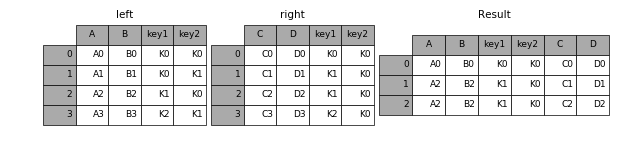

(from http://pandas.pydata.org/pandas-docs/stable/merging.html)

In [93]:
cols_wanted=['last_name_x', 'first_name_x', 'candidate_id', 'id', 'last_name_y']
dfcwci.merge(dfcand, left_on="candidate_id", right_on="id")[cols_wanted]

,last_name_x,first_name_x,candidate_id,id,last_name_y
0,Agee,Steven,16,16,Huckabee
1,Akin,Charles,16,16,Huckabee
2,Akin,Mike,16,16,Huckabee
3,Akin,Rebecca,16,16,Huckabee
4,Aldridge,Brittni,16,16,Huckabee
5,Allen,John D.,16,16,Huckabee
6,Allen,John D.,16,16,Huckabee
7,Allison,John W.,16,16,Huckabee
8,Allison,Rebecca,16,16,Huckabee
9,Allison,Rebecca,16,16,Huckabee


In [94]:
explicitjoinsel="""
SELECT 
    contributors.last_name, contributors.first_name, candidates.last_name 
FROM 
    contributors JOIN candidates 
ON contributors.candidate_id = candidates.id;
"""
out=make_query(explicitjoinsel)
make_frame(out, legend=["contributors.last_name", 
            "contributors.first_name",  "candidates.last_name"]).head()

,contributors.last_name,contributors.first_name,candidates.last_name
0,Agee,Steven,Huckabee
1,Akin,Charles,Huckabee
2,Akin,Mike,Huckabee
3,Akin,Rebecca,Huckabee
4,Aldridge,Brittni,Huckabee


In [95]:
explicitjoinsel="""
SELECT 
    COUNT(contributors.id), contributors.first_name, candidates.last_name 
FROM 
    contributors JOIN candidates 
ON contributors.candidate_id = candidates.id

GROUP BY candidates.last_name;
"""
out=make_query(explicitjoinsel)
make_frame(out, legend=["count(contributors.id)", 
            "contributors.first_name",  "candidates.last_name"])

,count(contributors.id),contributors.first_name,candidates.last_name
0,25,Lin,Clinton
1,25,TIMOTHY,Giuliani
2,22,John,Huckabee
3,25,SALEM,McCain
4,25,Ryan,Obama
5,25,Richard,Paul
6,25,GERALD,Romney


In [96]:
len(make_query("SELECT DISTINCT id, last_name FROM candidates;"))

17

### Outer JOIN

**left outer (contributors on candidates)**

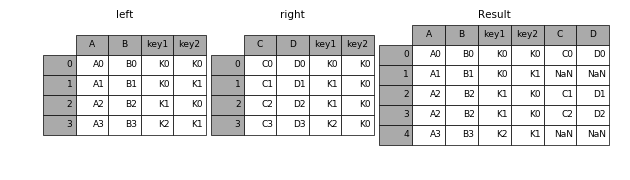

In [97]:
dfcwci.merge(dfcand, left_on="candidate_id", right_on="id", how="left")[cols_wanted]

,last_name_x,first_name_x,candidate_id,id,last_name_y
0,Agee,Steven,16,16,Huckabee
1,Akin,Charles,16,16,Huckabee
2,Akin,Mike,16,16,Huckabee
3,Akin,Rebecca,16,16,Huckabee
4,Aldridge,Brittni,16,16,Huckabee
5,Allen,John D.,16,16,Huckabee
6,Allen,John D.,16,16,Huckabee
7,Allison,John W.,16,16,Huckabee
8,Allison,Rebecca,16,16,Huckabee
9,Allison,Rebecca,16,16,Huckabee


In [98]:
explicitjoinsel="""
SELECT 
    COUNT(contributors.id), contributors.first_name, candidates.last_name,
        contributors.candidate_id, candidates.id
FROM 
    contributors LEFT OUTER JOIN candidates 
ON contributors.candidate_id = candidates.id

GROUP BY candidates.last_name;
"""
out=make_query(explicitjoinsel)
make_frame(out, legend=["count(contributors.id)", "contributors.first_name",  
            "contributors.candidate_id", "candidates.id", "candidates.last_name"])

,count(contributors.id),contributors.first_name,contributors.candidate_id,candidates.id,candidates.last_name
0,25,Lin,Clinton,34,34
1,25,TIMOTHY,Giuliani,22,22
2,22,John,Huckabee,16,16
3,25,SALEM,McCain,37,37
4,25,Ryan,Obama,20,20
5,25,Richard,Paul,32,32
6,25,GERALD,Romney,35,35


**right outer (contributors on candidates) = left outer (candidates on contributors)**

We do it thus as sqlite has no support for right outer or plain outer. If it did we could write:

    SELECT 
        COUNT(contributors.id), contributors.first_name, candidates.last_name 
    FROM 
        contributors **RIGHT OUTER JOIN** candidates 
    ON contributors.candidate_id = candidates.id

    GROUP BY candidates.last_name;
    
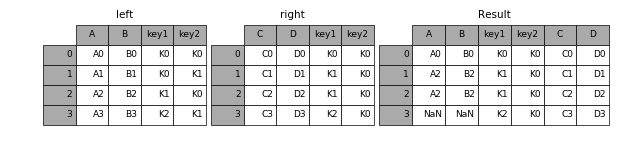

In [99]:
dfcwci.merge(dfcand, left_on="candidate_id", right_on="id", how="right")[cols_wanted]

,last_name_x,first_name_x,candidate_id,id,last_name_y
0,Agee,Steven,16.0,16,Huckabee
1,Akin,Charles,16.0,16,Huckabee
2,Akin,Mike,16.0,16,Huckabee
3,Akin,Rebecca,16.0,16,Huckabee
4,Aldridge,Brittni,16.0,16,Huckabee
5,Allen,John D.,16.0,16,Huckabee
6,Allen,John D.,16.0,16,Huckabee
7,Allison,John W.,16.0,16,Huckabee
8,Allison,Rebecca,16.0,16,Huckabee
9,Allison,Rebecca,16.0,16,Huckabee


In [100]:
explicitjoinsel="""
SELECT 
    COUNT(contributors.id), contributors.first_name, candidates.last_name, 
        contributors.candidate_id, candidates.id
FROM 
    candidates LEFT OUTER JOIN contributors 
ON contributors.candidate_id = candidates.id

GROUP BY candidates.last_name;
"""
out=make_query(explicitjoinsel)
make_frame(out, legend=["count(contributors.id)", "contributors.first_name",  
                    "contributors.candidate_id", "candidates.id", "candidates.last_name"])

,count(contributors.id),contributors.first_name,contributors.candidate_id,candidates.id,candidates.last_name
0,0,None,Biden,NaN,33
1,0,None,Brownback,NaN,36
2,25,Thomas,Clinton,34.0,34
3,0,None,Dodd,NaN,39
4,0,None,Edwards,NaN,26
5,25,WALTER,Giuliani,22.0,22
6,0,None,Gravel,NaN,24
7,22,William,Huckabee,16.0,16
8,0,None,Hunter,NaN,30
9,0,None,Kucinich,NaN,31


**full outer**

also not supported by sqlite

    SELECT 
        COUNT(contributors.id), contributors.first_name, candidates.last_name 
    FROM 
        contributors FULL OUTER JOIN candidates 
    ON contributors.candidate_id = candidates.id

    GROUP BY candidates.last_name;

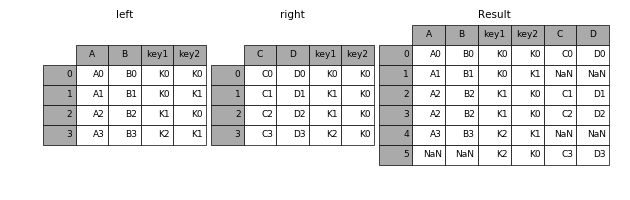

In [101]:
dfcwci.merge(dfcand, left_on="candidate_id", right_on="id", how="outer")[cols_wanted]

,last_name_x,first_name_x,candidate_id,id,last_name_y
0,Agee,Steven,16.0,16,Huckabee
1,Akin,Charles,16.0,16,Huckabee
2,Akin,Mike,16.0,16,Huckabee
3,Akin,Rebecca,16.0,16,Huckabee
4,Aldridge,Brittni,16.0,16,Huckabee
5,Allen,John D.,16.0,16,Huckabee
6,Allen,John D.,16.0,16,Huckabee
7,Allison,John W.,16.0,16,Huckabee
8,Allison,Rebecca,16.0,16,Huckabee
9,Allison,Rebecca,16.0,16,Huckabee


When to use which?

See this:

http://blog.codinghorror.com/a-visual-explanation-of-sql-joins/

### Pandas /SQL

In [102]:
pd.read_sql("SELECT * FROM candidates WHERE party= 'D';", db)

,id,first_name,last_name,middle_name,party
0,20,Barack,Obama,,D
1,24,Mike,Gravel,,D
2,26,John,Edwards,,D
3,29,Bill,Richardson,,D
4,31,Dennis,Kucinich,,D
5,33,Joseph,Biden,,D
6,34,Hillary,Clinton,R.,D
7,39,Christopher,Dodd,J.,D


In [103]:
pd.read_sql(implicitjoinsel, db)

,last_name,first_name,amount,last_name
0,Agee,Steven,500.0,Huckabee
1,Akin,Charles,100.0,Huckabee
2,Akin,Mike,1500.0,Huckabee
3,Akin,Rebecca,500.0,Huckabee
4,Aldridge,Brittni,250.0,Huckabee
5,Allen,John D.,1000.0,Huckabee
6,Allen,John D.,1300.0,Huckabee
7,Allison,John W.,1000.0,Huckabee
8,Allison,Rebecca,1000.0,Huckabee
9,Allison,Rebecca,200.0,Huckabee


This is very useful if the database is big and out of memory. Sqlite3 is the only db2api database supported. For any other database you should use SQLAlchemy. See, for eg: https://plot.ly/ipython-notebooks/big-data-analytics-with-pandas-and-sqlite/

In [104]:
db.close()

Useful Links
* http://sebastianraschka.com/Articles/sqlite3_database.html and http://sebastianraschka.com/Articles/2014_sqlite_in_python_tutorial.html#unique_indexes
* https://github.com/tthibo/SQL-Tutorial
* chrisalbon.com

And especially for R users:
* https://cran.r-project.org/web/packages/dplyr/vignettes/introduction.html
* https://gist.github.com/TomAugspurger/6e052140eaa5fdb6e8c0/